In [ ]:
# dengue_disease_outbreak_predictor.py
# Requirements: pandas, numpy, scikit-learn, matplotlib, joblib


import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


# Update the file paths based on the available files
FEATURES_FILE = '/content/dengue_features_train.csv'
LABELS_FILE = '/content/dengue_labels_train.csv'


# 1. Load data
X = pd.read_csv(FEATURES_FILE)
y = pd.read_csv(LABELS_FILE)


# Features expected columns: ['city','year','weekofyear','ndvi_ne','ndvi_nw','precipitation_amt_mm','reanalysis_temp_k', ...]
# Labels expected columns: ['city','year','weekofyear','total_cases']

In [36]:
# 2. Merge
# This line uses the pd.merge() function
# from the pandas library to combine the X and y DataFrames
# into a new DataFrame called data
# The on=['city','year','weekofyear'] argument specifies
# that the merge should be performed based on the common columns 'city', 'year', and 'weekofyear' in both DataFrames.
# This is similar to a SQL join operation.

data = pd.merge(X, y, on=['city','year','weekofyear'])


# 3. Basic cleaning
# Convert categorical/time to datetime index for each city
data['week_start'] = pd.to_datetime(data['year'].astype(str) + '-01-01') + pd.to_timedelta((data['weekofyear']-1)*7, unit='d')


# Impute numeric features with median per city
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['year','weekofyear','total_cases']]
for c in num_cols:
    data[c] = data.groupby('city')[c].transform(lambda g: g.fillna(g.median()))

In [37]:
# Check for remaining missing values after imputation
data.isnull().sum()

,0
city,0
year,0
weekofyear,0
week_start_date,0
ndvi_ne,0
ndvi_nw,0
ndvi_se,0
ndvi_sw,0
precipitation_amt_mm,0
reanalysis_air_temp_k,0


In [38]:
# 4. Feature engineering: lags for total_cases
data = data.sort_values(['city','week_start'])
for lag in [1,2,4,8]:
    data[f'cases_lag_{lag}'] = data.groupby('city')['total_cases'].shift(lag)

In [39]:
# Fill lag NaNs with 0 (or better: median/mean) — chosen 0 for simplicity
lag_cols = [c for c in data.columns if c.startswith('cases_lag_')]
data[lag_cols] = data[lag_cols].fillna(0)

In [40]:
# Temporal features
data['weekofyear_sin'] = np.sin(2*np.pi*data['weekofyear']/52)
data['weekofyear_cos'] = np.cos(2*np.pi*data['weekofyear']/52)

In [41]:
# Drop columns not used for modeling
drop_cols = ['year','weekofyear','week_start', 'week_start_date']
X_model = data.drop(columns=drop_cols + ['city','total_cases'])
y_model = data['total_cases']

In [42]:
# 5. Time-aware split: sort by date and split per city aggregated
# For simplicity, split by chronological order across the dataset (better: per city)
sorted_idx = np.argsort(data['week_start'].values)
train_size = int(len(data)*0.8)
train_idx = sorted_idx[:train_size]
test_idx = sorted_idx[train_size:]


X_train = X_model.iloc[train_idx]
X_test = X_model.iloc[test_idx]
y_train = y_model.iloc[train_idx]
y_test = y_model.iloc[test_idx]

In [43]:
# 6. Train a RandomForest baseline
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [44]:
# 7. Predict & evaluate
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(rmse) # Calculate RMSE by taking the square root
r2 = r2_score(y_test, y_pred)
print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)

MAE: 5.535895891509655
RMSE: 9.193761639511667
R2: 0.8157970608145817


In [45]:
# 8. Feature importance
fi = pd.Series(rf.feature_importances_, index=X_model.columns).sort_values(ascending=False)
print('\nTop features:\n', fi.head(20))


Top features:
 cases_lag_1                              0.910553
cases_lag_2                              0.015692
cases_lag_4                              0.007247
weekofyear_cos                           0.006387
reanalysis_precip_amt_kg_per_m2          0.006078
station_diur_temp_rng_c                  0.004654
cases_lag_8                              0.004331
reanalysis_tdtr_k                        0.003910
ndvi_sw                                  0.003476
weekofyear_sin                           0.003247
reanalysis_min_air_temp_k                0.003127
reanalysis_air_temp_k                    0.002804
station_precip_mm                        0.002658
station_avg_temp_c                       0.002612
ndvi_nw                                  0.002396
reanalysis_specific_humidity_g_per_kg    0.002376
ndvi_ne                                  0.002363
station_max_temp_c                       0.002341
ndvi_se                                  0.002311
reanalysis_relative_humidity_perce

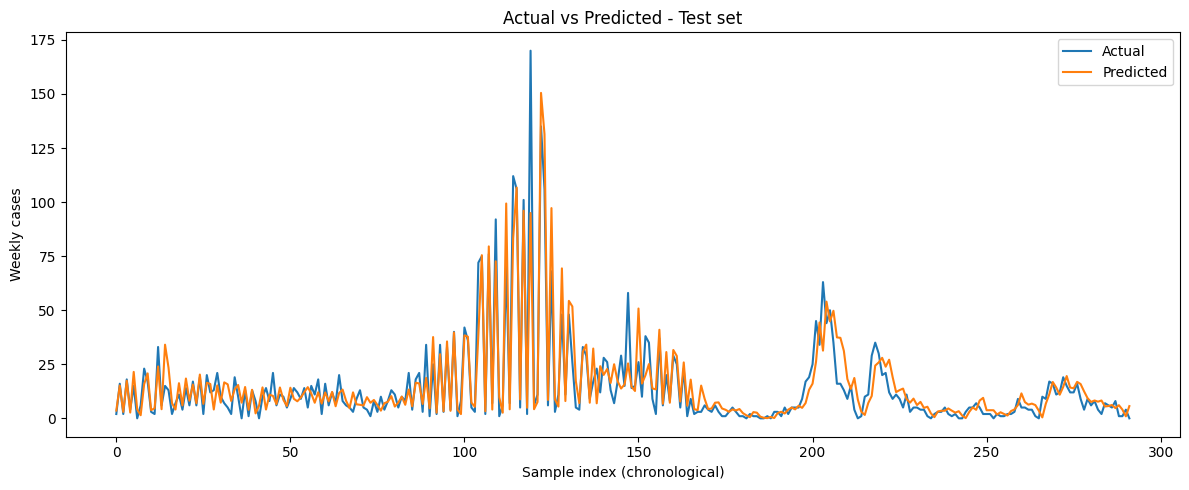

In [46]:
# 9. Plot actual vs predicted for a sample region/time window
plt.figure(figsize=(12,5))
plt.plot(range(len(y_test)), y_test.values, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted - Test set')
plt.xlabel('Sample index (chronological)')
plt.ylabel('Weekly cases')
plt.tight_layout()
plt.show()

In [47]:
# 10. Save model
joblib.dump(rf, 'rf_disease_model.joblib')

['rf_disease_model.joblib']